In [1]:
import pandas as pd
import os
from pathlib import Path
import re

def load_trading_data() -> dict[str, pd.DataFrame]:
    """
    Load trading data from CSV files in round directories into pandas DataFrames,
    keeping only the latest round's data for each day.

    Returns:
        Dict[str, pd.DataFrame]: Dictionary containing the following DataFrames:
            - 'prices': Price data for all days (latest round only)
            - 'trades': Trade data for all days (latest round only)
            - 'observations': Observation data for all days (latest round only)
    """
    # Dictionary to track the latest round for each day and data type
    latest_data = {
        'prices': {},
        'trades': {},
        'observations': {}
    }
    
    # Regex to find round directories (format: round-X-island-data-bottle)
    round_pattern = re.compile(r'^round-(\d+)-island-data-bottle$')
    
    # Regex to match files and extract type and day
    file_pattern = re.compile(r'^(prices|trades|observations)_round_(\d+)_day_(\d+)\.csv$')
    
    # Get the current directory
    current_dir = Path('.')
    print(current_dir.absolute())
    
    # First find all round directories
    round_dirs = []
    for item in current_dir.iterdir():
        if item.is_dir():
            match = round_pattern.match(item.name)
            if match:
                round_num = int(match.group(1))
                round_dirs.append((round_num, item))
    
    # Sort by round number to process in order
    round_dirs.sort()
    
    # Process each round directory
    for round_num, round_dir in round_dirs:
        for file in round_dir.iterdir():
            if file.is_file():
                match = file_pattern.match(file.name)
                if match:
                    data_type, _, day = match.groups()
                    day = int(day)
                    
                    # If we haven't seen this day yet, or if this round is newer
                    if day not in latest_data[data_type] or round_num > latest_data[data_type][day]['round']:
                        sep = ';' if data_type in ['prices', 'trades'] else ','
                        df = pd.read_csv(file, sep=sep)
                        df['day'] = day
                        df['round'] = round_num
                        if 'timestamp' in df.columns:
                            df = df.sort_values('timestamp')
                        
                        latest_data[data_type][day] = {
                            'round': round_num,
                            'data': df
                        }

    # Combine data for each type
    result = {}
    for key, day_data in latest_data.items():
        if day_data:  # Only add if we found any data
            dfs = [info['data'] for info in day_data.values()]
            result[key] = pd.concat(dfs, ignore_index=True)
            if 'timestamp' in result[key].columns:
                result[key].sort_values(['day', 'timestamp'], inplace=True)

    return result

def convert_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(t=(df['day']) * 1_000_000 + df['timestamp']).drop(columns=['day', 'timestamp'])

In [2]:
trading_data = load_trading_data()
prices = convert_timestamp(trading_data['prices']).drop(columns='round')

/Users/cartertran/Development/imc-prosperity-3


In [3]:
prices

product  bid_price_1  bid_volume_1  bid_price_2  \
0       VOLCANIC_ROCK_VOUCHER_10500         99.0          19.0          NaN   
1                     VOLCANIC_ROCK      10502.0         205.0          NaN   
2                         SQUID_INK       1968.0          30.0          NaN   
3       VOLCANIC_ROCK_VOUCHER_10250        273.0          19.0          NaN   
4        VOLCANIC_ROCK_VOUCHER_9500       1003.0          19.0          NaN   
...                             ...          ...           ...          ...   
739995               PICNIC_BASKET1      58434.0           1.0      58433.0   
739996   VOLCANIC_ROCK_VOUCHER_9750        356.0          11.0          NaN   
739997             RAINFOREST_RESIN       9992.0          35.0          NaN   
739998  VOLCANIC_ROCK_VOUCHER_10000        122.0          11.0          NaN   
739999  VOLCANIC_ROCK_VOUCHER_10250         10.0          11.0          NaN   

        bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0                NaN          NaN           NaN        100.0          19.0   
1                NaN          NaN           NaN      10504.0         146.0   
2                NaN          NaN           NaN       1971.0          30.0   
3                NaN          NaN           NaN        274.0          19.0   
4                NaN          NaN           NaN       1004.0          19.0   
...              ...          ...           ...          ...           ...   
739995          10.0      58432.0          30.0      58443.0           1.0   
739996           NaN          NaN           NaN        357.0          11.0   
739997           NaN          NaN           NaN       9999.0           1.0   
739998           NaN          NaN           NaN        123.0          11.0   
739999           NaN          NaN           NaN         11.0          11.0   

        ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0               NaN           NaN          NaN           NaN       99.5   
1           10505.0          59.0          NaN           NaN    10503.0   
2               NaN           NaN          NaN           NaN     1969.5   
3               NaN           NaN          NaN           NaN      273.5   
4               NaN           NaN          NaN           NaN     1003.5   
...             ...           ...          ...           ...        ...   
739995      58444.0          10.0      58445.0          30.0    58438.5   
739996          NaN           NaN          NaN           NaN      356.5   
739997      10008.0          35.0          NaN           NaN     9995.5   
739998          NaN           NaN          NaN           NaN      122.5   
739999          NaN           NaN          NaN           NaN       10.5   

        profit_and_loss        t  
0                   0.0        0  
1                   0.0        0  
2                   0.0        0  
3                   0.0        0  
4                   0.0        0  
...                 ...      ...  
739995              0.0  4999900  
739996              0.0  4999900  
739997              0.0  4999900  
739998              0.0  4999900  
739999              0.0  4999900  

[740000 rows x 16 columns]

In [4]:
prices = prices[prices['t'] <= 3_000_000]

In [5]:
import plotly.graph_objects as go

# 1. Extract mid prices for relevant products
products = ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'CROISSANTS', 'JAMS', 'DJEMBES']
mid_prices = prices[prices['product'].isin(products)][['product', 't', 'mid_price']]

# 2. Pivot to have products as columns, indexed by t
pivoted = mid_prices.pivot(index='t', columns='product', values='mid_price')

# 3. Compute synthetic prices
pivoted['PB1_synth'] = (
    6 * pivoted['CROISSANTS'] +
    3 * pivoted['JAMS'] +
    1 * pivoted['DJEMBES']
)
pivoted['PB2_synth'] = (
    4 * pivoted['CROISSANTS'] +
    2 * pivoted['JAMS']
)

# 4. Calculate spreads
pivoted['PB1_spread'] = pivoted['PICNIC_BASKET1'] - pivoted['PB1_synth']
pivoted['PB2_spread'] = pivoted['PICNIC_BASKET2'] - pivoted['PB2_synth']

# 5. Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pivoted.index, y=pivoted['PB1_spread'],
    mode='lines', name='PICNIC_BASKET1 Spread'
))
fig.add_trace(go.Scatter(
    x=pivoted.index, y=pivoted['PB2_spread'],
    mode='lines', name='PICNIC_BASKET2 Spread'
))
fig.update_layout(
    title='Spread of PICNIC_BASKET1 and PICNIC_BASKET2 vs. Synthetic Price',
    xaxis_title='t',
    yaxis_title='Spread (Basket Mid Price - Synthetic Price)',
    legend_title='Product'
)
fig.show()

In [6]:
import plotly.graph_objects as go

# Extract relevant mid prices
products = ['PICNIC_BASKET2', 'CROISSANTS', 'JAMS']
mid_prices = prices[prices['product'].isin(products)][['product', 't', 'mid_price']]

# Pivot to have products as columns, indexed by t
pivoted = mid_prices.pivot(index='t', columns='product', values='mid_price')

# Compute synthetic price for PB2
pivoted['PB2_synth'] = 4 * pivoted['CROISSANTS'] + 2 * pivoted['JAMS']

# Calculate spread
pivoted['PB2_spread'] = pivoted['PICNIC_BASKET2'] - pivoted['PB2_synth']

# Drop rows with missing data for a clean plot
pivoted_clean = pivoted.dropna(subset=['PICNIC_BASKET2', 'PB2_synth', 'PB2_spread'])

# Plot
fig = go.Figure()

# Plot actual and synthetic prices
fig.add_trace(go.Scatter(
    x=pivoted_clean.index, y=pivoted_clean['PICNIC_BASKET2'],
    mode='lines', name='PICNIC_BASKET2 Mid Price'
))
fig.add_trace(go.Scatter(
    x=pivoted_clean.index, y=pivoted_clean['PB2_synth'],
    mode='lines', name='Synthetic Price (4 CROISSANTS + 2 JAMS)'
))

# Plot spread on secondary y-axis
fig.add_trace(go.Scatter(
    x=pivoted_clean.index, y=pivoted_clean['PB2_spread'],
    mode='lines', name='Spread', yaxis='y2'
))

# Update layout for dual y-axes
fig.update_layout(
    title='PICNIC_BASKET2 vs. Synthetic Price and Spread',
    xaxis_title='t',
    yaxis=dict(
        title='Price',
        side='left'
    ),
    yaxis2=dict(
        title='Spread',
        overlaying='y',
        side='right'
    ),
    legend_title='Legend'
)

fig.show()

In [7]:
import plotly.graph_objects as go

# Extract relevant mid prices
products = ['PICNIC_BASKET2', 'CROISSANTS', 'JAMS']
mid_prices = prices[prices['product'].isin(products)][['product', 't', 'mid_price']]

# Pivot to have products as columns, indexed by t
pivoted = mid_prices.pivot(index='t', columns='product', values='mid_price')

# Compute synthetic price for PB2
pivoted['PB2_synth'] = 4 * pivoted['CROISSANTS'] + 2 * pivoted['JAMS']

# Calculate spread
pivoted['PB2_spread'] = pivoted['PICNIC_BASKET2'] - pivoted['PB2_synth']

# Drop rows with missing data for a clean plot
pivoted_clean = pivoted.dropna(subset=['PB2_spread', 'CROISSANTS', 'JAMS'])

fig = go.Figure()

# CROISSANTS on y1 (left)
fig.add_trace(go.Scatter(
    x=pivoted_clean.index, y=pivoted_clean['CROISSANTS'],
    mode='lines', name='CROISSANTS Mid Price',
    line=dict(width=2, color='royalblue'),
    yaxis='y1'
))

# JAMS on y2 (right)
fig.add_trace(go.Scatter(
    x=pivoted_clean.index, y=pivoted_clean['JAMS'],
    mode='lines', name='JAMS Mid Price',
    line=dict(width=2, color='orange', dash='dot'),
    yaxis='y2'
))

# Spread on y3 (far right)
fig.add_trace(go.Scatter(
    x=pivoted_clean.index, y=pivoted_clean['PB2_spread'],
    mode='lines', name='Spread (PB2 - Synthetic)',
    line=dict(width=2, color='black', dash='dash'),
    yaxis='y3'
))

fig.update_layout(
    title='PICNIC_BASKET2 Spread vs. CROISSANTS and JAMS (Separate Y Axes)',
    xaxis=dict(
        title='Synthetic Timestamp (t)',
        tickformat=',d'
    ),
    yaxis=dict(
        title='CROISSANTS Mid Price',
        title_font=dict(color='royalblue'),
        tickfont=dict(color='royalblue'),
        side='left'
    ),
    yaxis2=dict(
        title='JAMS Mid Price',
        title_font=dict(color='orange'),
        tickfont=dict(color='orange'),
        overlaying='y',
        side='right',
        anchor='x',
        position=0.85  # slightly inset from the far right
    ),
    yaxis3=dict(
        title='Spread (PB2 - Synthetic)',
        title_font=dict(color='black'),
        tickfont=dict(color='black'),
        overlaying='y',
        side='right',
        anchor='free',
        position=0.99  # at the far right
    ),
    legend_title='Legend',
    margin=dict(l=80, r=100, t=50, b=50)
)

fig.show()

In [8]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Extract relevant mid prices
products = ['PICNIC_BASKET2', 'CROISSANTS', 'JAMS']
mid_prices = prices[prices['product'].isin(products)][['product', 't', 'mid_price']]

# Pivot to have products as columns, indexed by t
pivoted = mid_prices.pivot(index='t', columns='product', values='mid_price')

# Drop rows with missing data
pivoted_clean = pivoted.dropna(subset=['PICNIC_BASKET2', 'CROISSANTS', 'JAMS'])

In [9]:
from sklearn.linear_model import Ridge

# Features and target
X = pivoted_clean[['CROISSANTS', 'JAMS']]
y = pivoted_clean['PICNIC_BASKET2']

# Fit the model with Ridge Regression
alpha_value = 0.1  # You can adjust this value to control regularization strength
model = Ridge(alpha=alpha_value)
model.fit(X, y)

# Coefficients and intercept
print("Intercept:", model.intercept_)
print("CROISSANTS coefficient:", model.coef_[0])
print("JAMS coefficient:", model.coef_[1])
print("R^2 score:", model.score(X, y))

Intercept: 4684.048193077404
CROISSANTS coefficient: 3.136400482326858
JAMS coefficient: 1.8520047621550493
R^2 score: 0.9027899719059979


In [10]:
print(f"PB2 ≈ {model.intercept_:.2f} + {model.coef_[0]:.2f} * CROISSANTS + {model.coef_[1]:.2f} * JAMS")

PB2 ≈ 4684.05 + 3.14 * CROISSANTS + 1.85 * JAMS


In [11]:
import plotly.graph_objects as go

# Predict PB2 prices
pivoted_clean['PB2_pred'] = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pivoted_clean.index, y=pivoted_clean['PICNIC_BASKET2'],
    mode='lines', name='Actual PB2'
))
fig.add_trace(go.Scatter(
    x=pivoted_clean.index, y=pivoted_clean['PB2_pred'],
    mode='lines', name='Predicted PB2', line=dict(dash='dash')
))
fig.update_layout(
    title='Actual vs. Predicted PB2 Price',
    xaxis_title='Synthetic Timestamp (t)',
    yaxis_title='PB2 Mid Price'
)
fig.show()

In [12]:
# Calculate residuals
pivoted_clean['residuals'] = pivoted_clean['PICNIC_BASKET2'] - pivoted_clean['PB2_pred']

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=pivoted_clean['PB2_pred'],
    y=pivoted_clean['residuals'],
    mode='markers',
    marker=dict(size=3, color='firebrick'),
    name='Residuals'
))

fig.add_hline(y=0, line_dash='dash', line_color='black')

fig.update_layout(
    title='Residual Plot: PB2 Actual vs. Predicted',
    xaxis_title='Predicted PB2 Price',
    yaxis_title='Residuals (Actual - Predicted)',
    showlegend=False
)

fig.show()

In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Extract relevant mid prices
products = ['PICNIC_BASKET1', 'CROISSANTS', 'JAMS', 'DJEMBES']
mid_prices = prices[prices['product'].isin(products)][['product', 't', 'mid_price']]

# Pivot to have products as columns, indexed by t
pivoted_pb1 = mid_prices.pivot(index='t', columns='product', values='mid_price')

# Drop rows with missing data
pivoted_pb1_clean = pivoted_pb1.dropna(subset=['PICNIC_BASKET1', 'CROISSANTS', 'JAMS', 'DJEMBES'])

In [14]:
from sklearn.linear_model import Ridge

# Features and target
X_pb1 = pivoted_pb1_clean[['CROISSANTS', 'JAMS', 'DJEMBES']]
y_pb1 = pivoted_pb1_clean['PICNIC_BASKET1']

# Fit the original Linear Regression model to get baseline coefficients
original_model = LinearRegression()
original_model.fit(X_pb1, y_pb1)
original_coefs = original_model.coef_

# Fit the Ridge Regression model with a small alpha
alpha_value = 0.1  # Small alpha for less regularization
model_pb1 = Ridge(alpha=alpha_value)
model_pb1.fit(X_pb1, y_pb1)

# Coefficients and intercept
print("Original Coefficients:", original_coefs)
print("Ridge Intercept:", model_pb1.intercept_)
print("Ridge Coefficients:", model_pb1.coef_)
print("R^2 score:", model_pb1.score(X_pb1, y_pb1))

Original Coefficients: [6.86727184 2.01801563 1.05595311]
Ridge Intercept: 2023.9700921310432
Ridge Coefficients: [6.86727166 2.01801567 1.05595314]
R^2 score: 0.9321910550312467


In [15]:
print(f"PB1 ≈ {model_pb1.intercept_:.2f} + {model_pb1.coef_[0]:.2f} * CROISSANTS + {model_pb1.coef_[1]:.2f} * JAMS + {model_pb1.coef_[2]:.2f} * DJEMBES")

PB1 ≈ 2023.97 + 6.87 * CROISSANTS + 2.02 * JAMS + 1.06 * DJEMBES


In [16]:
import plotly.graph_objects as go

# Predict PB1 prices
pivoted_pb1_clean['PB1_pred'] = model_pb1.predict(X_pb1)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pivoted_pb1_clean.index, y=pivoted_pb1_clean['PICNIC_BASKET1'],
    mode='lines', name='Actual PB1'
))
fig.add_trace(go.Scatter(
    x=pivoted_pb1_clean.index, y=pivoted_pb1_clean['PB1_pred'],
    mode='lines', name='Predicted PB1', line=dict(dash='dash')
))
fig.update_layout(
    title='Actual vs. Predicted PB1 Price',
    xaxis_title='Synthetic Timestamp (t)',
    yaxis_title='PB1 Mid Price'
)
fig.show()

In [17]:
# Calculate residuals
pivoted_pb1_clean['residuals'] = pivoted_pb1_clean['PICNIC_BASKET1'] - pivoted_pb1_clean['PB1_pred']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pivoted_pb1_clean['PB1_pred'],
    y=pivoted_pb1_clean['residuals'],
    mode='markers',
    marker=dict(size=3, color='firebrick'),
    name='Residuals'
))
fig.add_hline(y=0, line_dash='dash', line_color='black')
fig.update_layout(
    title='Residual Plot: PB1 Actual vs. Predicted',
    xaxis_title='Predicted PB1 Price',
    yaxis_title='Residuals (Actual - Predicted)',
    showlegend=False
)
fig.show()

In [18]:
# Calculate residuals
pivoted_pb1_clean['residuals'] = pivoted_pb1_clean['PICNIC_BASKET1'] - pivoted_pb1_clean['PB1_pred']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pivoted_pb1_clean.index,  # Use the 't' column for the x-axis
    y=pivoted_pb1_clean['residuals'],
    mode='markers',
    marker=dict(size=3, color='firebrick'),
    name='Residuals'
))
fig.add_hline(y=0, line_dash='dash', line_color='black')
fig.update_layout(
    title='Residual Plot: PB1 Residuals over Time',
    xaxis_title='Time',
    yaxis_title='Residuals (Actual - Predicted)',
    showlegend=False
)
fig.show()

In [19]:
import pandas as pd
from sklearn.linear_model import Ridge

# Assuming 'pivoted_pb1_clean' is your DataFrame with mid prices and 'PICNIC_BASKET1' column

# Define the products
products = ['CROISSANTS', 'JAMS', 'DJEMBES']

# Define lags
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Add lagged features
for product in products:
    for lag in lags:
        pivoted_pb1_clean[f'{product}_lag{lag}'] = pivoted_pb1_clean[product].shift(lag)

# Drop rows with NaN values after adding lagged features
pivoted_pb1_clean = pivoted_pb1_clean.dropna()

# Prepare features and target
X = pivoted_pb1_clean[[f'{product}_lag1' for product in products]]
y = pivoted_pb1_clean['PICNIC_BASKET1']  # Set the target to PICNIC_BASKET1

# Split the data into training and testing sets
split_idx = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

# Fit a Ridge regression model
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

# Optionally, evaluate the model
train_score = ridge_model.score(X_train, y_train)
test_score = ridge_model.score(X_test, y_test)

print(f'Training Score: {train_score}')
print(f'Test Score: {test_score}')

Training Score: 0.9182834337309088
Test Score: -1.6210703586270903


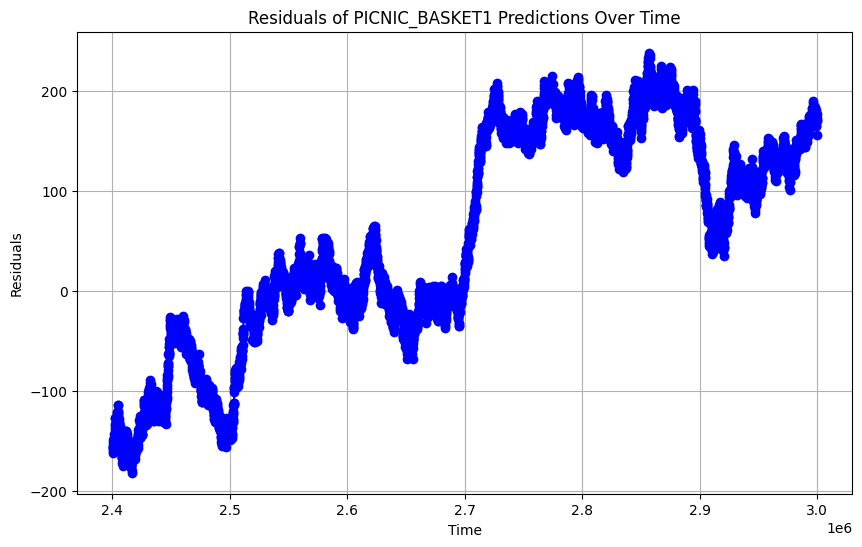

In [20]:
import matplotlib.pyplot as plt

# Predict the PICNIC_BASKET1 prices for the test set
y_pred = ridge_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals over time
plt.figure(figsize=(10, 6))
plt.plot(pivoted_pb1_clean.index[split_idx:], residuals, marker='o', linestyle='-', color='b')
plt.title('Residuals of PICNIC_BASKET1 Predictions Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [21]:
import pandas as pd
from sklearn.linear_model import Ridge

# Assuming 'pivoted_pb1_clean' is your DataFrame with mid prices and 'PICNIC_BASKET1' column

# Define the products
products = ['CROISSANTS', 'JAMS']

# Define lags
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Add lagged features
for product in products:
    for lag in lags:
        pivoted_clean[f'{product}_lag{lag}'] = pivoted_clean[product].shift(lag)

# Drop rows with NaN values after adding lagged features
pivoted_clean = pivoted_clean.dropna()

# Prepare features and target
X = pivoted_clean[[f'{product}_lag1' for product in products]]
y = pivoted_clean['PICNIC_BASKET2']  # Set the target to PICNIC_BASKET2

# Split the data into training and testing sets
split_idx = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

# Fit a Ridge regression model
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

# Optionally, evaluate the model
train_score = ridge_model.score(X_train, y_train)
test_score = ridge_model.score(X_test, y_test)

print(f'Training Score: {train_score}')
print(f'Test Score: {test_score}')

Training Score: 0.8962760243301181
Test Score: -0.2568408253306491


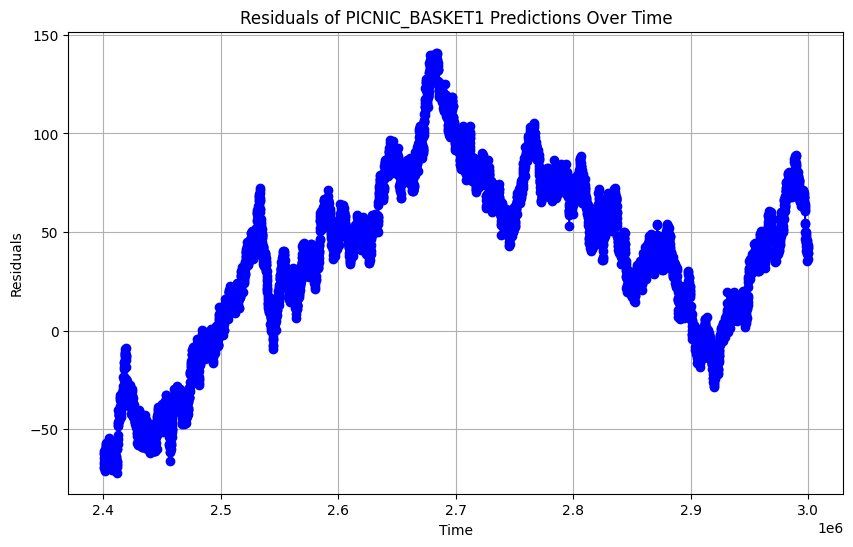

In [22]:
import matplotlib.pyplot as plt

# Predict the PICNIC_BASKET1 prices for the test set
y_pred = ridge_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals over time
plt.figure(figsize=(10, 6))
plt.plot(pivoted_clean.index[split_idx:], residuals, marker='o', linestyle='-', color='b')
plt.title('Residuals of PICNIC_BASKET1 Predictions Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# maybe we just find the historical mean...

In [23]:
pivoted_pb1_clean

product  CROISSANTS  DJEMBES    JAMS  PICNIC_BASKET1      PB1_pred  \
t                                                                    
1000         4321.5  13493.5  6631.5         59238.5  59331.859229   
1100         4321.5  13493.5  6631.5         59237.5  59331.859229   
1200         4321.5  13493.5  6631.5         59236.5  59331.859229   
1300         4321.5  13493.5  6631.5         59231.5  59331.859229   
1400         4321.5  13493.5  6631.5         59234.5  59331.859229   
...             ...      ...     ...             ...           ...   
2999600      4239.5  13295.5  6526.0         58415.5  58346.763577   
2999700      4239.5  13295.5  6526.0         58415.0  58346.763577   
2999800      4240.5  13296.5  6526.0         58420.5  58354.686802   
2999900      4241.5  13296.5  6525.0         58427.0  58359.536058   
3000000      4241.5  13296.5  6523.0         58416.5  58355.500027   

product   residuals  CROISSANTS_lag1  CROISSANTS_lag2  CROISSANTS_lag3  \
t                                                                        
1000     -93.359229           4321.5           4322.0           4321.5   
1100     -94.359229           4321.5           4321.5           4322.0   
1200     -95.359229           4321.5           4321.5           4321.5   
1300    -100.359229           4321.5           4321.5           4321.5   
1400     -97.359229           4321.5           4321.5           4321.5   
...             ...              ...              ...              ...   
2999600   68.736423           4239.5           4239.5           4239.5   
2999700   68.236423           4239.5           4239.5           4239.5   
2999800   65.813198           4239.5           4239.5           4239.5   
2999900   67.463942           4240.5           4239.5           4239.5   
3000000   60.999973           4241.5           4240.5           4239.5   

product  CROISSANTS_lag4  ...  DJEMBES_lag1  DJEMBES_lag2  DJEMBES_lag3  \
t                         ...                                             
1000              4322.0  ...       13493.5       13493.5       13493.5   
1100              4321.5  ...       13493.5       13493.5       13493.5   
1200              4322.0  ...       13493.5       13493.5       13493.5   
1300              4321.5  ...       13493.5       13493.5       13493.5   
1400              4321.5  ...       13493.5       13493.5       13493.5   
...                  ...  ...           ...           ...           ...   
2999600           4239.5  ...       13296.5       13296.5       13296.5   
2999700           4239.5  ...       13295.5       13296.5       13296.5   
2999800           4239.5  ...       13295.5       13295.5       13296.5   
2999900           4239.5  ...       13296.5       13295.5       13295.5   
3000000           4239.5  ...       13296.5       13296.5       13295.5   

product  DJEMBES_lag4  DJEMBES_lag5  DJEMBES_lag6  DJEMBES_lag7  DJEMBES_lag8  \
t                                                                               
1000          13493.5       13493.5       13493.5       13493.5       13493.5   
1100          13493.5       13493.5       13493.5       13493.5       13493.5   
1200          13493.5       13493.5       13493.5       13493.5       13493.5   
1300          13493.5       13493.5       13493.5       13493.5       13493.5   
1400          13493.5       13493.5       13493.5       13493.5       13493.5   
...               ...           ...           ...           ...           ...   
2999600       13295.5       13296.5       13295.0       13295.0       13294.5   
2999700       13296.5       13295.5       13296.5       13295.0       13295.0   
2999800       13296.5       13296.5       13295.5       13296.5       13295.0   
2999900       13296.5       13296.5       13296.5       13295.5       13296.5   
3000000       13295.5       13296.5       13296.5       13296.5       13295.5   

product  DJEMBES_lag9  DJEMBES_lag10  
t                                     
1000          1349

In [24]:
pivoted_clean

product  CROISSANTS    JAMS  PICNIC_BASKET2      PB2_pred  residuals  \
t                                                                      
1000         4321.5  6631.5         30506.0  30519.572458 -13.572458   
1100         4321.5  6631.5         30506.5  30519.572458 -13.072458   
1200         4321.5  6631.5         30509.0  30519.572458 -10.572458   
1300         4321.5  6631.5         30506.5  30519.572458 -13.072458   
1400         4321.5  6631.5         30506.0  30519.572458 -13.572458   
...             ...     ...             ...           ...        ...   
2999600      4239.5  6526.0         30069.0  30067.001116   1.998884   
2999700      4239.5  6526.0         30069.0  30067.001116   1.998884   
2999800      4240.5  6526.0         30072.0  30070.137516   1.862484   
2999900      4241.5  6525.0         30075.5  30071.421912   4.078088   
3000000      4241.5  6523.0         30072.5  30067.717902   4.782098   

product  CROISSANTS_lag1  CROISSANTS_lag2  CROISSANTS_lag3  CROISSANTS_lag4  \
t                                                                             
1000              4321.5           4322.0           4321.5           4322.0   
1100              4321.5           4321.5           4322.0           4321.5   
1200              4321.5           4321.5           4321.5           4322.0   
1300              4321.5           4321.5           4321.5           4321.5   
1400              4321.5           4321.5           4321.5           4321.5   
...                  ...              ...              ...              ...   
2999600           4239.5           4239.5           4239.5           4239.5   
2999700           4239.5           4239.5           4239.5           4239.5   
2999800           4239.5           4239.5           4239.5           4239.5   
2999900           4240.5           4239.5           4239.5           4239.5   
3000000           4241.5           4240.5           4239.5           4239.5   

product  CROISSANTS_lag5  ...  JAMS_lag1  JAMS_lag2  JAMS_lag3  JAMS_lag4  \
t                         ...                                               
1000              4321.5  ...     6632.0     6632.0     6632.0     6632.5   
1100              4322.0  ...     6631.5     6632.0     6632.0     6632.0   
1200              4321.5  ...     6631.5     6631.5     6632.0     6632.0   
1300              4322.0  ...     6631.5     6631.5     6631.5     6632.0   
1400              4321.5  ...     6631.5     6631.5     6631.5     6631.5   
...                  ...  ...        ...        ...        ...        ...   
2999600           4239.5  ...     6526.0     6526.0     6526.0     6526.0   
2999700           4239.5  ...     6526.0     6526.0     6526.0     6526.0   
2999800           4239.5  ...     6526.0     6526.0     6526.0     6526.0   
2999900           4239.5  ...     6526.0     6526.0     6526.0     6526.0   
3000000           4239.5  ...     6525.0     6526.0     6526.0     6526.0   

product  JAMS_lag5  JAMS_lag6  JAMS_lag7  JAMS_lag8  JAMS_lag9  JAMS_lag10  
t                                                                           
1000        6632.0     6632.0     6632.0     6632.0     6631.5      6632.0  
1100        6632.5     6632.0     6632.0     6632.0     6632.0      6631.5  
1200        6632.0     6632.5     6632.0     6632.0     6632.0      6632.0  
1300        6632.0     6632.0     6632.5     6632.0     6632.0      6632.0  
1400        6632.0     6632.0     6632.0     6632.5     6632.0      6632.0  
...            ...        ...        ...        ...        ...         ...  
2999600     6526.0     6526.0     6526.0     6526.0     6526.0      6526.0  
2999700     6526.0     6526.0     6526.0     6526.0     6526.0      6526.0  
2999800     6526.0     6526.0     6526.0     6526.0     6526.0      6526.0  
2999900     6526.0     6526.0     6526.0     6526.0     6526.0      6526.0  
3000000     6526.0     6526.0     6526.0     6526.0     6526.0      6526.0  

[29991 rows x 25 columns]

In [25]:
def calc_avg_spread(pivoted_clean):
    basket = 'PICNIC_BASKET1' if 'PICNIC_BASKET1' in pivoted_clean.columns else 'PICNIC_BASKET2'
    if basket == 'PICNIC_BASKET1':
        spreads = pivoted_clean[basket] - 6 * pivoted_clean['CROISSANTS'] - 3 * pivoted_clean['JAMS'] - 1 * pivoted_clean['DJEMBES']
    else:
        spreads = pivoted_clean[basket] - 4 * pivoted_clean['CROISSANTS'] - 2 * pivoted_clean['JAMS']
    return spreads.mean()

In [26]:
calc_avg_spread(pivoted_pb1_clean)

np.float64(57.69249108065753)

In [27]:
calc_avg_spread(pivoted_clean)

np.float64(22.592961221699845)

In [31]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter

# Assuming 'pivoted_clean' is your DataFrame with the necessary columns
# Define the observation matrix P_t (prices of picnic basket and ingredients)
P_t = pivoted_pb1_clean[['CROISSANTS', 'JAMS', 'DJEMBES']].values

# Define the target S_t (e.g., another basket or a combination)
S_t = pivoted_pb1_clean['PICNIC_BASKET1'].values

# Initial guess for the state (cointegrating weights)
initial_state_mean = np.zeros(P_t.shape[1])

# Define the Kalman Filter
kf = KalmanFilter(
    transition_matrices=np.eye(P_t.shape[1]),  # Identity matrix for state transition
    observation_matrices=P_t,
    initial_state_mean=initial_state_mean,
    observation_covariance=1.0,  # R, tune this
    transition_covariance=0.01 * np.eye(P_t.shape[1])  # Q, tune this
)

# Estimate the state (cointegrating weights) over time
state_means, state_covariances = kf.filter(S_t)

# The state_means array contains the estimated \(\beta_t\) over time

ValueError: The shape of all parameters is not consistent.  Please re-check their values.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, product in enumerate(['PICNIC_BASKET1', 'CROISSANTS', 'JAMS']):
    plt.plot(state_means[:, i], label=f'{product} weight')
plt.title('Estimated Cointegrating Weights Over Time')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.legend()
plt.show()